In [1]:
#load requirements for working with PCs
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget
import numpy as np
import tensorflow as tf
import time
import cv2

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 20*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

import sys
import os
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
sys.path.append(parent_directory+"/point_cloud_rectification")
from ICET_spherical import ICET
from linear_corrector import LC

from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
from scipy.spatial.transform import Rotation as R
from matplotlib import pyplot as plt
import copy
import trimesh


from pillow_heif import register_heif_opener
from matplotlib import pyplot as p
from colmapParsingUtils import *
from scipy.spatial.transform import Rotation as R
import cv2

from tqdm import tqdm_notebook as tqdm
from PIL import Image

tf.compat.v1.enable_eager_execution()


%load_ext autoreload
%autoreload 2
%autosave 180
# %matplotlib notebook

2024-04-13 11:08:38.031128: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-13 11:08:38.131879: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-13 11:08:38.539383: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-04-13 11:08:38.539435: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-13 11:08:39.273576: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-13 11:08:39.274336: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-13 11:08:39.274554: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-13 11:08:39.274699: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Autosaving every 180 seconds


In [2]:
#load raw point cloud data from Newer College Dataset

#NEWER COLLEGE
idx = 900 #1500 
fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
pc1 = np.load(fn1)
pc1 = np.flip(pc1, axis = 0)#flip to maintain CCW convention used in VICET

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]
## purple -> green
color = 255*np.linspace(0,1,len(pc1)) 
cname = np.array([255-color, color, 255-color]).T.tolist()
disp.append(Points(pc1, c=cname,  r = 3.5, alpha =0.5))
print(len(pc1) / 128)

#remove NaNs
# pc1[pc1[:,0]>64] = 100
# pc1[pc1[:,0]<-64] = 100
# pc1 = np.nan_to_num(pc1, nan=0.0)

plt.show(disp, "Raw Point Cloud")
ViewInteractiveWidget(plt.window)

512.0


ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# Convert Point Cloud to Depth Image

(64, 1024)


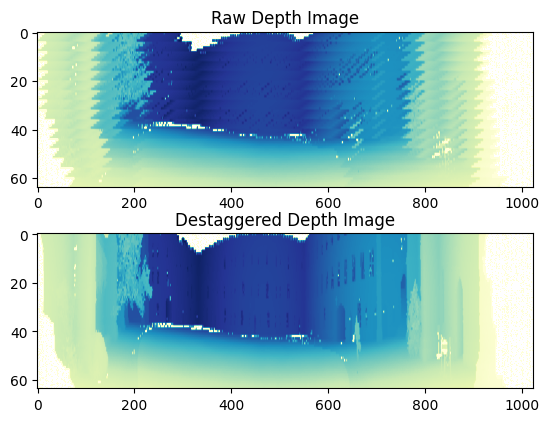

In [3]:
# %matplotlib notebook
pc1_spherical = LC.c2s(LC,pc1).numpy() #[r, theta, phi]
pcs = np.reshape(pc1_spherical, [-1,64,3])
pcs = np.flip(pcs, axis = 1)
raw_data = pcs[:,:,0].T

# print(np.shape(data))

data = np.zeros([64, 1024])
for i in range(np.shape(data)[0]//4):
    #shift left
#     data[4*i,:-18] = raw_data[4*i,18:]
#     data[4*i+1,:-12] = raw_data[4*i+1,12:]
#     data[4*i+2,:-6] = raw_data[4*i+2,6:]
#     data[4*i+3,:] = raw_data[4*i+3,:]
#     #shift right
#     data[4*i,:] = raw_data[4*i,:]
#     data[4*i+1,6:] = raw_data[4*i+1,:-6]
#     data[4*i+2,12:] = raw_data[4*i+2,:-12]
#     data[4*i+3,18:] = raw_data[4*i+3,:-18]
    #keep centered-- avoids needing to fill in gaps
#     data[4*i,:-9] = raw_data[4*i,9:]
#     data[4*i+1,:-3] = raw_data[4*i+1,3:]
#     data[4*i+2,3:] = raw_data[4*i+2,:-3]
#     data[4*i+3,9:] = raw_data[4*i+3,:-9]
    data[4*i,1:-8] = raw_data[4*i,9:]
    data[4*i+1,1:-2] = raw_data[4*i+1,3:]
    data[4*i+2,4:] = raw_data[4*i+2,:-4]
    data[4*i+3,10:] = raw_data[4*i+3,:-10]
    
# data = np.flip(data, axis =1)

fig, ax = p.subplots(2,1)
ax[0].set_title("Raw Depth Image")
ax[0].imshow(raw_data, cmap = "YlGnBu", norm='log')
ax[0].set_aspect(5)
ax[1].set_title("Destaggered Depth Image")
ax[1].imshow(data, cmap = "YlGnBu", norm='log')
ax[1].set_aspect(5)
print(np.shape(data))


# Reproject 2D Depth image back to 3D point cloud

#### IMPORTANT: look into pixel_shift_by_row parameter from OUSTER
https://ouster.com/insights/blog/firmware-2-4-industry-standard-protocols-and-improved-alerts

In [4]:
#OS1 LiDAR Intrinsics
#as specified in datasheet
# phimin = np.deg2rad(-16.6) #supposed to be this
# phimax = np.deg2rad(16.6)
#angles required to reproduce observed point clouds
phimin = np.deg2rad(-16) 
phimax = np.deg2rad(17.75)
depth_img  = data.T

new_point_cloud_spherical = np.zeros([np.shape(pcs)[0]*np.shape(pcs)[1],3])
pc1_spherical = new_point_cloud_spherical

count = 0
for w in range(np.shape(depth_img)[0]):
    for h in range(np.shape(depth_img)[1]):
        new_point_cloud_spherical[count,0] = depth_img[w,h] #radius
        new_point_cloud_spherical[count,1] = 2*np.pi*(w/np.shape(depth_img)[0]) #theta
        new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/np.shape(depth_img)[1]) #phi
        count+= 1

new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy()
new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z 

#shape image to have same angular field of view in width and height
vert_fov = np.rad2deg(phimax-phimin)
# print(vert_fov)
# vert_fov/360
# print((vert_fov/360)*np.shape(pcs)[0])

In [5]:
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

## purple -> green
color = 255*np.linspace(0,1,len(new_point_cloud_cart)) 
cname = np.array([255-color, color, 255-color]).T.tolist()
disp.append(Points(new_point_cloud_cart, c=cname,  r = 3.5, alpha =0.5))
# disp.append(Points(new_point_cloud_cart[::32], c='red',  r = 3.5, alpha =0.8))
# disp.append(Points(new_point_cloud_cart[::4], c='blue',  r = 5., alpha =0.125))

disp.append(Points(pc1, c = 'blue', r = 3.5, alpha = 0.5))

plt.show(disp, "Raw Point Cloud")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# Load ground truth poses (map frame) and convert to NeRF LH Coordinate System

(-150.0, 30.0)

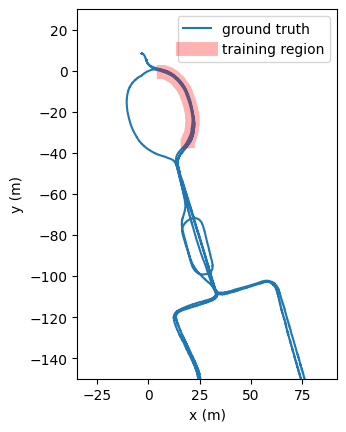

In [6]:
from os import listdir

dir_name = "/media/derm/06EF-127D4/Newer College Dataset/"
experiment_name = "01_short_experiment-20230331T172433Z-009/01_short_experiment/"
fn_gt = dir_name + experiment_name + "ground_truth/registered_poses.csv"
# print(fn_gt)

#sec,nsec,x,y,z,qx,qy,qz,qw
gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
# print(np.shape(gt))
# print(gt[20,:])

scan_dir = dir_name + experiment_name + "raw_format/ouster_zip_files/ouster_scan-007/ouster_scan/"
list_of_all_scans = sorted(listdir(scan_dir))

#plot ground truth trajectory
fig, ax = p.subplots()
ax.set_aspect('equal')
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.plot(gt[:,2], gt[:,3], label = "ground truth")

#superimpose trajectory from <short_experiment_01>
# first_timestamp = int(list_of_all_scans[0][6:16])
# last_timestamp = int(list_of_all_scans[-1][6:16]) #scrape timestamp from name of velodyne .pcl file
# first_idx = np.argwhere(gt[:,0] == first_timestamp)[0][0]
# last_idx = np.argwhere(gt[:,0] == last_timestamp)[0][0]
first_idx = 600 #1450 #700
last_idx = 1000 #1950 #1000

ax.plot(gt[first_idx:last_idx,2], gt[first_idx:last_idx,3], 'r', lw = 10, alpha = 0.3, label = 'training region')
ax.legend(loc = 'best')
ax.set_ylim([-150,30])

In [ ]:
from time import sleep
#convert gt from xyzquat to homogenous rotation matrix
n_images = 50 #20 
n_rots = 8 #8 
#Ouster OS1-64
phimin = np.deg2rad(-16) 
phimax = np.deg2rad(17.75)
#just for debug
# phimin = np.deg2rad(-6) 
# phimax = np.deg2rad(27.75)
# phimin = -0.53529248 #rad
# phimax = 0.18622663 #rad
vert_fov = np.rad2deg(phimax-phimin)

poses = np.zeros([n_images*n_rots,4,4])
images = np.ones([n_images*n_rots, 64, 64, 2]) #depth image and raydrop

#focal length (in pixels) = Image Size / (2 tan(FOV/2)) #needs to be array!
focal = np.array(np.shape(images)[1]/(2*np.tan((phimax-phimin)/2))) #default image size
H, W = images.shape[1:3]
print(focal, H, W)

for i in range(n_images):
    #load point cloud
    idx = i*10 + 600 #1450 #700    
    fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
    pc1 = np.load(fn1)
    pc1 = np.flip(pc1, axis = 0)# uncomment to flip and maintain CCW convention used in VICET

    #convert to depth image
    pc1_spherical = LC.c2s(LC,pc1).numpy() #[r, theta, phi]
    pcs = np.reshape(pc1_spherical, [-1,64,3])
    pcs = np.flip(pcs, axis = 1)
    raw_data = pcs[:,:,:]
    raw_data = np.transpose(pcs, [1,0,2])

    #destagger depth images (OS1 unit has delay in sensor return bus)
    data = np.zeros([64, 1024])
    for k in range(np.shape(data)[0]//4):
        data[4*k,1:-8] = raw_data[4*k,9:,0]
        data[4*k+1,1:-2] = raw_data[4*k+1,3:,0]
        data[4*k+2,4:] = raw_data[4*k+2,:-4,0]
        data[4*k+3,10:] = raw_data[4*k+3,:-10,0]
    data = np.flip(data, axis =1)

#     print(np.shape(data))
#     print(np.shape(pc1_spherical))

    for j in range(n_rots):
        
        #get cropped depth image ~~~~~~~~~~~~~~~~~~~~
#         pcs = np.flip(data, axis = 1) #flip vertical
#         pcs = np.flip(pcs, axis = 0) #flip horizontal to look at first clockwise patch of scan sweep 
#         pcs = pcs.T
        pcs = data.T
        
        #resize image to 64x64
        image_width = int((vert_fov/360)*np.shape(pcs)[0])        
#         pcs = pcs[j*image_width:(j+1)*image_width,:].T #SQUARE
        pcs = pcs[(j+1)*image_width:(j+2)*image_width,:].T #SQUARE-- skip beginning of frame (blocked by human)
#         pcs = pcs[(j*image_width//32):((j+1)*image_width//32),:,0].T #32nds
        pcs = cv2.resize(pcs, (64, 64), cv2.INTER_NEAREST) #keep square
        #TEST
#         pcs = np.flip(pcs, axis =1)
    
        #preserve aspect ratio and focal length but just take middle
#         pcs = pcs[:,31:33] #uncomment for 32nds
        images[j+(i*n_rots),:,:,0] = pcs #save depth information to first channel
        a = np.argwhere(pcs == 0)
        #TODO: why do some distant windows register as being close (but not non-returns)??
        images[j+(i*n_rots),a[:,0],a[:,1],1] = 0 #save raydrop mask to 2nd channel
        
        #get transformation matrix ~~~~~~~~~~~~~~~~~~
        rotm = np.eye(4)
        rotm[1,3] = -gt[idx,2] #x
        rotm[2,3] = gt[idx,3] #y
        rotm[0,3] = -gt[idx,4] #z
        rotm[:3,:3] = R.from_quat(gt[idx,5:]).as_matrix() 

# #         #orient yellow (-z) pointing forward
        fix1 = R.from_euler('xyz', [0,-np.pi/2,0]).as_matrix()
        fix2 = R.from_euler('xyz', [np.pi/2,0,0]).as_matrix()
        rotm[:3,:3] = rotm[:3,:3] @ fix1 @ fix2

        #unreliable?
        temp = R.from_matrix(rotm[:3,:3]).as_euler('zxy')
        rotm[:3,:3] = R.from_euler('xyz', [temp[0], temp[1], -temp[2]]).as_matrix()
                
        #account for image crop in rotation
        #swapping sign convention from what was used in synthetic data(?) ...+j*(phimax-phimin)
#         crop_angle = 0 #DEBUG ONLY
#         crop_angle = -(phimax-phimin)/2 + j*(phimax-phimin) #square
        crop_angle = -(phimax-phimin)/2 + (j+1)*(phimax-phimin) #square-- but skip beginning of frame
        #         crop_angle = -(phimax-phimin)/64 - j*(phimax-phimin)/32 #2-pixels wide
        
        #account for the fact that sensor points back and to the left
        crop_angle -= np.pi/4 
        rotm_crop = R.from_euler('xyz', [0,-crop_angle + np.pi/2,0]).as_matrix() #looks better
        rotm[:3,:3] = rotm[:3,:3] @ rotm_crop

        #also need to account for the fact that the LIDAR beam isn't actually centered at horizon
        sensor_elevation_zero_rotm = R.from_euler('xyz', [(phimin+phimax)/2,0,0]).as_matrix() #was this
#         sensor_elevation_zero_rotm = R.from_euler('xyz', [0,(phimin+phimax)/2,0]).as_matrix() #TODO: not sure if rot about y or z
        rotm[:3,:3] = rotm[:3,:3] @ sensor_elevation_zero_rotm

        #flip x and z axis
#         rotm[0,-1], rotm[2,-1] = rotm[2,-1], rotm[0,-1] 
#         rotm[0,-1], rotm[1,-1] = rotm[1,-1], rotm[0,-1]  #test

# #         # flip sign of axis
#         rotm[0:3,2] *= -1 #was this
#         rotm[0:3,1] *= -1 #was this
#         rotm[0:3,0] *= -1 #test
#         rotm = rotm[[1,0,2,3],:] #was this
#         rotm = rotm[[2,0,1,3],:]
#         rotm[2,:] *= -1 # flip whole world upside down
#         #translate all frames above xy plane
        rotm[2,-1] += 45 
        
        #Linearly scale down translations and ranges ~~~~~~~~~~~~~~~~~~~
        rotm[:3,-1] *= 0.05
        images[j+(i*n_rots),:,:,0] *= 0.05
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
        poses[j+(i*n_rots)] = rotm

images = images.astype(np.float32)
poses = poses.astype(np.float32)
        
# test on one only
testimg, testpose = images[(n_images*n_rots)-1], poses[(n_images*n_rots)-1]
images = images[:((n_images*n_rots)-1),...,:3]
poses = poses[:((n_images*n_rots)-1)]

# #90/10 split
# cutoff = (n_images*9)//10
# print(cutoff)
# testimg, testpose = images[cutoff:], poses[cutoff:]
# images = images[:cutoff,...,:3]
# poses = poses[:cutoff]

In [ ]:
print(np.shape(images))

In [92]:
#draw orientation of frames used for each patch in world frame
phimin = np.deg2rad(-16) 
phimax = np.deg2rad(17.75)
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]
for i in range(np.shape(images)[0]-1):
    #convert depth image back to point cloud
    count = 0
    for w in range(np.shape(images)[1]):
        for h in range(np.shape(images)[2]):
            new_point_cloud_spherical[count,0] = images[i,w,h,0] #radius
            new_point_cloud_spherical[count,1] = -(phimax-phimin)*(w/np.shape(images)[1]) #theta
            new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/np.shape(images)[2]) #phi
            count+= 1
            
    #transform each to base frame using <poses>
    new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy()
    new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z -- does this indicate an error somewhere???

    #draw frames for each sub-scan 
    alph = 1-(i%(n_rots)/n_rots)
    #forward view direction (-z in NeRF c2w convention)
    headings = poses[i,:3,:3] @ np.array([0,0,-0.03])
    disp.append(Arrows(poses[i,:3,-1][None,:], (poses[i,:3,-1] + headings)[None,:], c = "yellow", alpha = alph))
    # x
    headings = poses[i,:3,:3] @ np.array([.03,0,0])
    disp.append(Arrows(poses[i,:3,-1][None,:], (poses[i,:3,-1] + headings)[None,:], c = "red", alpha = alph))
    #y
    headings = poses[i,:3,:3] @ np.array([0,.03,0])
    disp.append(Arrows(poses[i,:3,-1][None,:], (poses[i,:3,-1] + headings)[None,:], c = "green", alpha = alph))
    #z
    headings = poses[i,:3,:3] @ np.array([0,0,.03])
    disp.append(Arrows(poses[i,:3,-1][None,:], (poses[i,:3,-1] + headings)[None,:], c = "blue", alpha = alph))
    
disp.append(Points(np.array([[0,0,0]]), r = 10, c = 'black'))
plt.show(disp, "Training Data Sample")
ViewInteractiveWidget(plt.window)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

5806
5807
5808
5809
5810
5811
5812
5813
5814
5815
5816
5817
5818
5819
5820
5821
5822
5823
5824
5825
5826
5827
5828
5829
5830
5831
5832
5833
5834
5835
5836
5837
5838
5839
5840
5841
5842
5843
5844
5845
5846
5847
5848
5849
5850
5851
5852
5853
5854
5855
5856
5857
5858
5859
5860
5861
5862
5863
5864
5865
5866
5867
5868
5869
5870
5871
5872
5873
5874
5875
5876
5877
5878
5879
5880
5881
5882
5883
5884
5885
5886
5887
5888
5889
5890
5891
5892
5893
5894
5895
5896
5897
5898
5899
5900
5901
5902
5903
5904
5905
5906
5907
5908
5909
5910
5911
5912
5913
5914
5915
5916
5917
5918
5919
5920
5921
5922
5923
5924
5925
5926
5927
5928
5929
5930
5931
5932
5933
5934
5935
5936
5937
5938
5939
5940
5941
5942
5943
5944
5945
5946
5947
5948
5949
5950
5951
5952
5953
5954
5955
5956
5957
5958
5959
5960
5961
5962
5963
5964
5965
5966
5967
5968
5969
5970
5971
5972
5973
5974
5975
5976
5977
5978
5979
5980
5981
5982
5983
5984
5985
5986
5987
5988
5989
5990
5991
5992
5993
5994
5995
5996
5997
5998
5999
6000
6001
6002
6003
6004
6005


8166
8167
8168
8169
8170
8171
8172
8173
8174
8175
8176
8177
8178
8179
8180
8181
8182
8183
8184
8185
8186
8187
8188
8189
8190
8191
8192
8193
8194
8195
8196
8197
8198
8199
8200
8201
8202
8203
8204
8205
8206
8207
8208
8209
8210
8211
8212
8213
8214
8215
8216
8217
8218
8219
8220
8221
8222
8223
8224
8225
8226
8227
8228
8229
8230
8231
8232
8233
8234
8235
8236
8237
8238
8239
8240
8241
8242
8243
8244
8245
8246
8247
8248
8249
8250
8251
8252
8253
8254
8255
8256
8257
8258
8259
8260
8261
8262
8263
8264
8265
8266
8267
8268
8269
8270
8271
8272
8273
8274
8275
8276
8277
8278
8279
8280
8281
8282
8283
8284
8285
8286
8287
8288
8289
8290
8291
8292
8293
8294
8295
8296
8297
8298
8299
8300
8301
8302
8303
8304
8305
8306
8307
8308
8309
8310
8311
8312
8313
8314
8315
8316
8317
8318
8319
8320
8321
8322
8323
8324
8325
8326
8327
8328
8329
8330
8331
8332
8333
8334
8335
8336
8337
8338
8339
8340
8341
8342
8343
8344
8345
8346
8347
8348
8349
8350
8351
8352
8353
8354
8355
8356
8357
8358
8359
8360
8361
8362
8363
8364
8365


10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241
10242
10243
10244
10245
10246
10247
10248
10249
10250
10251
10252
10253
10254
10255
10256
10257
10258
10259
10260
10261
10262
10263
10264
10265
10266
10267
10268
10269
10270
10271
10272
10273
10274
10275
10276
10277
10278
10279
10280
10281
10282
10283
10284
10285
10286
10287
10288
10289
10290
10291
10292
10293
10294
10295
10296
10297
10298
10299
10300
10301
10302
10303
10304
10305
10306
10307
10308
10309
10310
10311
10312
10313
10314
10315
10316
10317
10318
10319
10320
10321
10322
10323
10324
10325
10326
10327
10328
10329
10330
10331
10332
10333
10334
10335
10336
10337
10338
10339
10340
10341
10342
10343
10344
10345
10346
10347
10348
10349
10350
10351
10352
10353
10354
10355
10356
10357
10358
10359
10360
10361
10362
10363
1036

12773
12774
12775
12776
12777
12778
12779
12780
12781
12782
12783
12784
12785
12786
12787
12788
12789
12790
12791
12792
12793
12794
12795
12796
12797
12798
12799
12800
12801
12802
12803
12804
12805
12806
12807
12808
12809
12810
12811
12812
12813
12814
12815
12816
12817
12818
12819
12820
12821
12822
12823
12824
12825
12826
12827
12828
12829
12830
12831
12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
1293

14723
14724
14725
14726
14727
14728
14729
14730
14731
14732
14733
14734
14735
14736
14737
14738
14739
14740
14741
14742
14743
14744
14745
14746
14747
14748
14749
14750
14751
14752
14753
14754
14755
14756
14757
14758
14759
14760
14761
14762
14763
14764
14765
14766
14767
14768
14769
14770
14771
14772
14773
14774
14775
14776
14777
14778
14779
14780
14781
14782
14783
14784
14785
14786
14787
14788
14789
14790
14791
14792
14793
14794
14795
14796
14797
14798
14799
14800
14801
14802
14803
14804
14805
14806
14807
14808
14809
14810
14811
14812
14813
14814
14815
14816
14817
14818
14819
14820
14821
14822
14823
14824
14825
14826
14827
14828
14829
14830
14831
14832
14833
14834
14835
14836
14837
14838
14839
14840
14841
14842
14843
14844
14845
14846
14847
14848
14849
14850
14851
14852
14853
14854
14855
14856
14857
14858
14859
14860
14861
14862
14863
14864
14865
14866
14867
14868
14869
14870
14871
14872
14873
14874
14875
14876
14877
14878
14879
14880
14881
14882
14883
14884
14885
14886
14887
14888
1488

17655
17656
17657
17658
17659
17660
17661
17662
17663
17664
17665
17666
17667
17668
17669
17670
17671
17672
17673
17674
17675
17676
17677
17678
17679
17680
17681
17682
17683
17684
17685
17686
17687
17688
17689
17690
17691
17692
17693
17694
17695
17696
17697
17698
17699
17700
17701
17702
17703
17704
17705
17706
17707
17708
17709
17710
17711
17712
17713
17714
17715
17716
17717
17718
17719
17720
17721
17722
17723
17724
17725
17726
17727
17728
17729
17730
17731
17732
17733
17734
17735
17736
17737
17738
17739
17740
17741
17742
17743
17744
17745
17746
17747
17748
17749
17750
17751
17752
17753
17754
17755
17756
17757
17758
17759
17760
17761
17762
17763
17764
17765
17766
17767
17768
17769
17770
17771
17772
17773
17774
17775
17776
17777
17778
17779
17780
17781
17782
17783
17784
17785
17786
17787
17788
17789
17790
17791
17792
17793
17794
17795
17796
17797
17798
17799
17800
17801
17802
17803
17804
17805
17806
17807
17808
17809
17810
17811
17812
17813
17814
17815
17816
17817
17818
17819
17820
1782

19492
19493
19494
19495
19496
19497
19498
19499
19500
19501
19502
19503
19504
19505
19506
19507
19508
19509
19510
19511
19512
19513
19514
19515
19516
19517
19518
19519
19520
19521
19522
19523
19524
19525
19526
19527
19528
19529
19530
19531
19532
19533
19534
19535
19536
19537
19538
19539
19540
19541
19542
19543
19544
19545
19546
19547
19548
19549
19550
19551
19552
19553
19554
19555
19556
19557
19558
19559
19560
19561
19562
19563
19564
19565
19566
19567
19568
19569
19570
19571
19572
19573
19574
19575
19576
19577
19578
19579
19580
19581
19582
19583
19584
19585
19586
19587
19588
19589
19590
19591
19592
19593
19594
19595
19596
19597
19598
19599
19600
19601
19602
19603
19604
19605
19606
19607
19608
19609
19610
19611
19612
19613
19614
19615
19616
19617
19618
19619
19620
19621
19622
19623
19624
19625
19626
19627
19628
19629
19630
19631
19632
19633
19634
19635
19636
19637
19638
19639
19640
19641
19642
19643
19644
19645
19646
19647
19648
19649
19650
19651
19652
19653
19654
19655
19656
19657
1965

24195
24196
24197
24198
24199
24200
24201
24202
24203
24204
24205
24206
24207
24208
24209
24210
24211
24212
24213
24214
24215
24216
24217
24218
24219
24220
24221
24222
24223
24224
24225
24226
24227
24228
24229
24230
24231
24232
24233
24234
24235
24236
24237
24238
24239
24240
24241
24242
24243
24244
24245
24246
24247
24248
24249
24250
24251
24252
24253
24254
24255
24256
24257
24258
24259
24260
24261
24262
24263
24264
24265
24266
24267
24268
24269
24270
24271
24272
24273
24274
24275
24276
24277
24278
24279
24280
24281
24282
24283
24284
24285
24286
24287
24288
24289
24290
24291
24292
24293
24294
24295
24296
24297
24298
24299
24300
24301
24302
24303
24304
24305
24306
24307
24308
24309
24310
24311
24312
24313
24314
24315
24316
24317
24318
24319
24320
24321
24322
24323
24324
24325
24326
24327
24328
24329
24330
24331
24332
24333
24334
24335
24336
24337
24338
24339
24340
24341
24342
24343
24344
24345
24346
24347
24348
24349
24350
24351
24352
24353
24354
24355
24356
24357
24358
24359
24360
2436

26274
26275
26276
26277
26278
26279
26280
26281
26282
26283
26284
26285
26286
26287
26288
26289
26290
26291
26292
26293
26294
26295
26296
26297
26298
26299
26300
26301
26302
26303
26304
26305
26306
26307
26308
26309
26310
26311
26312
26313
26314
26315
26316
26317
26318
26319
26320
26321
26322
26323
26324
26325
26326
26327
26328
26329
26330
26331
26332
26333
26334
26335
26336
26337
26338
26339
26340
26341
26342
26343
26344
26345
26346
26347
26348
26349
26350
26351
26352
26353
26354
26355
26356
26357
26358
26359
26360
26361
26362
26363
26364
26365
26366
26367
26368
26369
26370
26371
26372
26373
26374
26375
26376
26377
26378
26379
26380
26381
26382
26383
26384
26385
26386
26387
26388
26389
26390
26391
26392
26393
26394
26395
26396
26397
26398
26399
26400
26401
26402
26403
26404
26405
26406
26407
26408
26409
26410
26411
26412
26413
26414
26415
26416
26417
26418
26419
26420
26421
26422
26423
26424
26425
26426
26427
26428
26429
26430
26431
26432
26433
26434
26435
26436
26437
26438
26439
2644

28652
28653
28654
28655
28656
28657
28658
28659
28660
28661
28662
28663
28664
28665
28666
28667
28668
28669
28670
28671
28672
28673
28674
28675
28676
28677
28678
28679
28680
28681
28682
28683
28684
28685
28686
28687
28688
28689
28690
28691
28692
28693
28694
28695
28696
28697
28698
28699
28700
28701
28702
28703
28704
28705
28706
28707
28708
28709
28710
28711
28712
28713
28714
28715
28716
28717
28718
28719
28720
28721
28722
28723
28724
28725
28726
28727
28728
28729
28730
28731
28732
28733
28734
28735
28736
28737
28738
28739
28740
28741
28742
28743
28744
28745
28746
28747
28748
28749
28750
28751
28752
28753
28754
28755
28756
28757
28758
28759
28760
28761
28762
28763
28764
28765
28766
28767
28768
28769
28770
28771
28772
28773
28774
28775
28776
28777
28778
28779
28780
28781
28782
28783
28784
28785
28786
28787
28788
28789
28790
28791
28792
28793
28794
28795
28796
28797
28798
28799
28800
28801
28802
28803
28804
28805
28806
28807
28808
28809
28810
28811
28812
28813
28814
28815
28816
28817
2881

30671
30672
30673
30674
30675
30676
30677
30678
30679
30680
30681
30682
30683
30684
30685
30686
30687
30688
30689
30690
30691
30692
30693
30694
30695
30696
30697
30698
30699
30700
30701
30702
30703
30704
30705
30706
30707
30708
30709
30710
30711
30712
30713
30714
30715
30716
30717
30718
30719
30720
30721
30722
30723
30724
30725
30726
30727
30728
30729
30730
30731
30732
30733
30734
30735
30736
30737
30738
30739
30740
30741
30742
30743
30744
30745
30746
30747
30748
30749
30750
30751
30752
30753
30754
30755
30756
30757
30758
30759
30760
30761
30762
30763
30764
30765
30766
30767
30768
30769
30770
30771
30772
30773
30774
30775
30776
30777
30778
30779
30780
30781
30782
30783
30784
30785
30786
30787
30788
30789
30790
30791
30792
30793
30794
30795
30796
30797
30798
30799
30800
30801
30802
30803
30804
30805
30806
30807
30808
30809
30810
30811
30812
30813
30814
30815
30816
30817
30818
30819
30820
30821
30822
30823
30824
30825
30826
30827
30828
30829
30830
30831
30832
30833
30834
30835
30836
3083

32981
32982
32983
32984
32985
32986
32987
32988
32989
32990
32991
32992
32993
32994
32995
32996
32997
32998
32999
33000
33001
33002
33003
33004
33005
33006
33007
33008
33009
33010
33011
33012
33013
33014
33015
33016
33017
33018
33019
33020
33021
33022
33023
33024
33025
33026
33027
33028
33029
33030
33031
33032
33033
33034
33035
33036
33037
33038
33039
33040
33041
33042
33043
33044
33045
33046
33047
33048
33049
33050
33051
33052
33053
33054
33055
33056
33057
33058
33059
33060
33061
33062
33063
33064
33065
33066
33067
33068
33069
33070
33071
33072
33073
33074
33075
33076
33077
33078
33079
33080
33081
33082
33083
33084
33085
33086
33087
33088
33089
33090
33091
33092
33093
33094
33095
33096
33097
33098
33099
33100
33101
33102
33103
33104
33105
33106
33107
33108
33109
33110
33111
33112
33113
33114
33115
33116
33117
33118
33119
33120
33121
33122
33123
33124
33125
33126
33127
33128
33129
33130
33131
33132
33133
33134
33135
33136
33137
33138
33139
33140
33141
33142
33143
33144
33145
33146
3314

35494
35495
35496
35497
35498
35499
35500
35501
35502
35503
35504
35505
35506
35507
35508
35509
35510
35511
35512
35513
35514
35515
35516
35517
35518
35519
35520
35521
35522
35523
35524
35525
35526
35527
35528
35529
35530
35531
35532
35533
35534
35535
35536
35537
35538
35539
35540
35541
35542
35543
35544
35545
35546
35547
35548
35549
35550
35551
35552
35553
35554
35555
35556
35557
35558
35559
35560
35561
35562
35563
35564
35565
35566
35567
35568
35569
35570
35571
35572
35573
35574
35575
35576
35577
35578
35579
35580
35581
35582
35583
35584
35585
35586
35587
35588
35589
35590
35591
35592
35593
35594
35595
35596
35597
35598
35599
35600
35601
35602
35603
35604
35605
35606
35607
35608
35609
35610
35611
35612
35613
35614
35615
35616
35617
35618
35619
35620
35621
35622
35623
35624
35625
35626
35627
35628
35629
35630
35631
35632
35633
35634
35635
35636
35637
35638
35639
35640
35641
35642
35643
35644
35645
35646
35647
35648
35649
35650
35651
35652
35653
35654
35655
35656
35657
35658
35659
3566

38375
38376
38377
38378
38379
38380
38381
38382
38383
38384
38385
38386
38387
38388
38389
38390
38391
38392
38393
38394
38395
38396
38397


ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [ ]:
# %matplotlib notebook
fig, ax = p.subplots(2,5)
ax[0,0].set_title("depth image patches for training")

# ax[0,0].imshow(images[0,:,:,0])#, vmin=0, vmax=64)
# ax[0,1].imshow(images[1,:,:,0])#, vmin=0, vmax=64)
# ax[0,2].imshow(images[2,:,:,0])#, vmin=0, vmax=64)
# ax[0,3].imshow(images[3,:,:,0])#, vmin=0, vmax=64)
# ax[0,4].imshow(images[4,:,:,0])#, vmin=0, vmax=64)

ax[0,0].imshow(images[-4,:,:,0])#, vmin=0, vmax=64)
ax[0,1].imshow(images[-3,:,:,0])#, vmin=0, vmax=64)
ax[0,2].imshow(images[-2,:,:,0])#, vmin=0, vmax=64)
ax[0,3].imshow(images[-1,:,:,0])#, vmin=0, vmax=64)
ax[0,4].imshow(testimg[:,:,0])#, vmin=0, vmax=64)

ax[1,0].set_title("ray drop masks")
ax[1,0].imshow(images[-4,:,:,1],cmap="gray", vmin=0,vmax=1)
ax[1,1].imshow(images[-3,:,:,1],cmap="gray", vmin=0,vmax=1)
ax[1,2].imshow(images[-2,:,:,1],cmap="gray", vmin=0,vmax=1)
ax[1,3].imshow(images[-1,:,:,1],cmap="gray", vmin=0,vmax=1)
ax[1,4].imshow(testimg[:,:,1],cmap="gray", vmin=0,vmax=1)

# Debug: draw frames

In [88]:
#Raw frames, in Newer College RHCS convention
phimin = np.deg2rad(-16) 
phimax = np.deg2rad(17.75)

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

# new_point_cloud_spherical = np.zeros([np.shape(images)[1]*np.shape(images)[2],3])

for i in range(n_images):
    idx = i*20 + 600    
    
    rotm = np.eye(4)
    rotm[0,3] = gt[idx,2] #x
    rotm[1,3] = gt[idx,3] #y
    rotm[2,3] = gt[idx,4] #z
    rotm[:3,:3] = R.from_quat(gt[idx,5:]).as_matrix() 
    
    #draw frames for each sub-scan 
    alph = 1-(i/n_images)
    #forward view direction (-z in NeRF c2w convention)
    headings = rotm[:3,:3] @ np.array([0,0,-1])
    disp.append(Arrows(rotm[:3,-1][None,:], (rotm[:3,-1] + headings)[None,:], c = "yellow", alpha = alph))
    # x
    headings = rotm[:3,:3] @ np.array([1,0,0])
    disp.append(Arrows(rotm[:3,-1][None,:], (rotm[:3,-1] + headings)[None,:], c = "red", alpha = alph))
    #y
    headings = rotm[:3,:3] @ np.array([0,1,0])
    disp.append(Arrows(rotm[:3,-1][None,:], (rotm[:3,-1] + headings)[None,:], c = "green", alpha = alph))
    #z
    headings = rotm[:3,:3] @ np.array([0,0,1])
    disp.append(Arrows(rotm[:3,-1][None,:], (rotm[:3,-1] + headings)[None,:], c = "blue", alpha = alph))

disp.append(Points(np.array([[0,0,0]]), r = 10, c = 'black'))
plt.show(disp, "Actual Ground Truth Path (Newer College Frame)")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# Train Network

In [103]:
def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

L_embed =  15 #20 #15 #10 #6
embed_fn = posenc
# L_embed = 0
# embed_fn = tf.identity

def init_model(D=8, W=256): #8,256
    relu = tf.keras.layers.ReLU()    
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed)) 
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.concat([outputs, inputs], -1)

    #extend "color" channels to small MLP after output of density channel
    sigma_channel = dense(1, act=None)(outputs)
    
    #start ray drop branch
    rd_start = tf.concat([outputs, inputs], -1)
    rd_channel = dense(128, act=relu)(outputs)
#     rd_channel = dense(128, act=relu)(rd_channel)
    rd_channel = dense(128, act=relu)(rd_channel)
    rd_channel = dense(1, act=tf.keras.activations.sigmoid)(rd_channel)
    out = tf.concat([sigma_channel, rd_channel], -1)
    model = tf.keras.Model(inputs=inputs, outputs=out)
    
    return model


def get_rays(H, W,c2w, phimin_patch, phimax_patch):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')

    #spherical projection model (ours)~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    phimin = np.deg2rad(-16) 
    phimax = np.deg2rad(17.75)

    #[r, theta, phi]
    dirs_test = tf.stack([-tf.ones_like(i), #r
                          #theta
#                           ((i-32)/64)*(phimax-phimin), #for square images (FOV_vert==FOV_horiz)
#                           (i - (1024//(2*n_rots)))  /(2048//(2*n_rots)) * (2*np.pi/n_rots), #for uninterpolated images
                            (i - (W//2))  /(W) * (2*np.pi/(1024//W)), #just use W
                          #phi
#                           (phimax + phimin)/2 + ((-j+31.5)/63)*(phimax-phimin) -np.pi/2 #for single vertical patch
                          #need to manually account for elevation angle of patch (can not be inferred from c2w)
                          (phimax_patch + phimin_patch)/2 + ((-j+(H/2))/(H))*(phimax_patch-phimin_patch) -np.pi/2
                         ], -1)
    dirs_test = tf.reshape(dirs_test,[-1,3])
    dirs_test = LC.s2c(LC, dirs_test)     
    
    rotm = R.from_euler('xyz', [0,-np.pi/2 + (phimax + phimin)/2,0]).as_matrix()
    dirs_test = dirs_test @ rotm
    dirs_test = dirs_test @ tf.transpose(c2w[:3,:3])
    dirs = dirs_test @ (c2w[:3,:3] 
                          @ R.from_euler('xyz', [0,0,np.pi/2]).as_matrix()
                          @ np.linalg.pinv(c2w[:3,:3]) )

    dirs = tf.reshape(dirs, [H,W,3])

    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * np.eye(3), -1) 
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    
        
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d


def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=True):

    def batchify(fn, chunk=1024*512): #1024*128 converged for box3 #1024*32 in TinyNeRF
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    
    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples) 
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    #[image_height, image_width, batch_size, 3]
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    
    # Run network
    pts_flat = tf.reshape(pts, [-1,3])
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
#     raw = tf.reshape(raw, list(pts.shape[:-1]) + [4]) #OG nerf
#     raw = tf.reshape(raw, list(pts.shape[:-1]) + [1])  #[depth]
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [2]) # [depth, ray drop] 
    
    # Compute opacities and colors
    #OG TinyNeRF
#     sigma_a = tf.nn.relu(raw[...,3])
#     rgb = tf.math.sigmoid(raw[...,:3]) 
    #LiDAR-NeRF
    sigma_a = tf.nn.relu(raw[...,0])
    ray_drop = tf.nn.relu(raw[...,1])
#     ray_drop = tf.math.sigmoid(raw[...,1]) #test

    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1) 
    alpha = 1.-tf.exp(-sigma_a * dists)  
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)

#     print("weights[...,None]",np.shape(weights[..., None]))
#     print("ray_drop", np.shape(ray_drop))
#     print(np.shape(weights), np.shape(z_vals))
    
    depth_map = tf.reduce_sum(weights * z_vals, -1)
    ray_drop_map = tf.reduce_sum(weights * ray_drop, -1) #axis was -2, changed to -1 
    acc_map = tf.reduce_sum(weights, -1)

#     return depth_map, acc_map
    return depth_map, acc_map, ray_drop_map

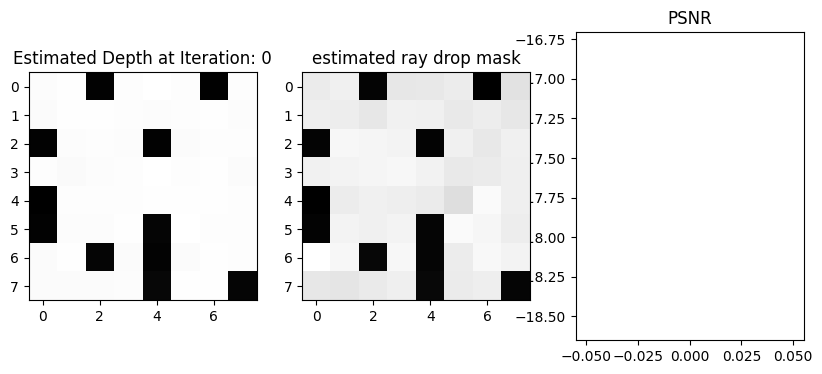

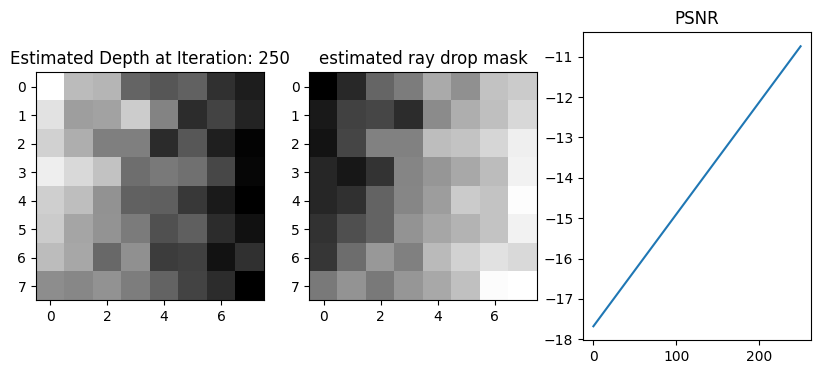

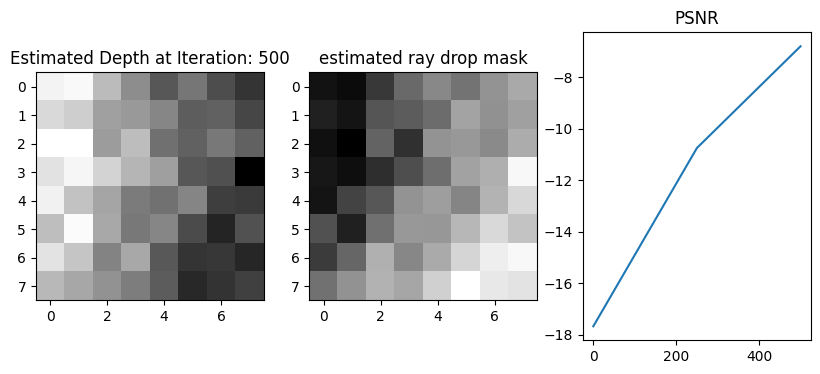

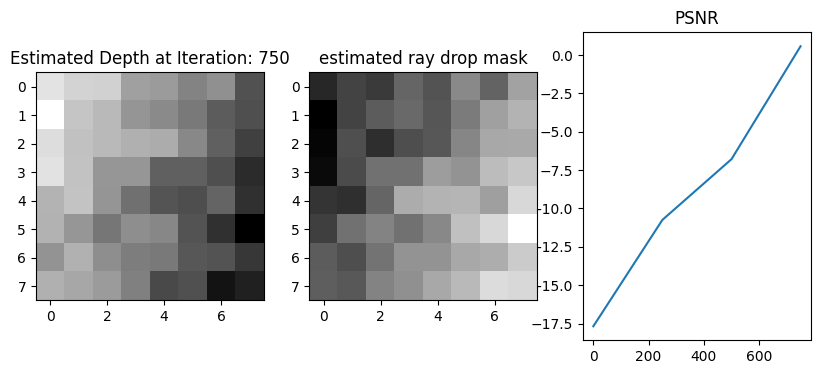

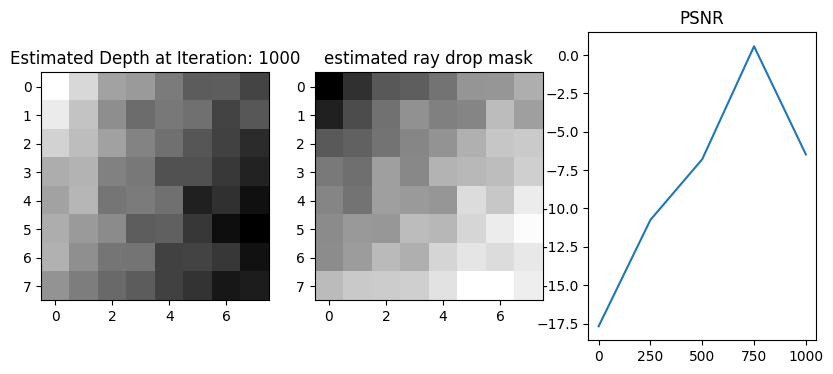

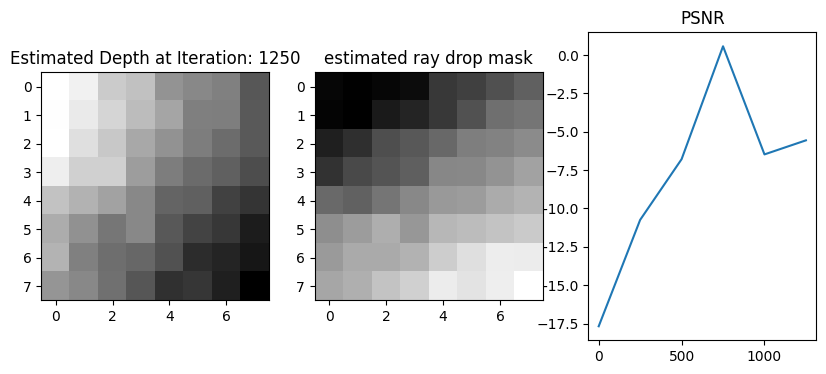

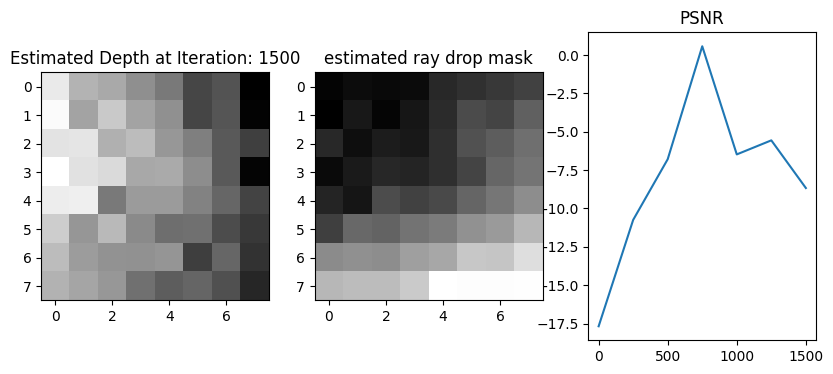

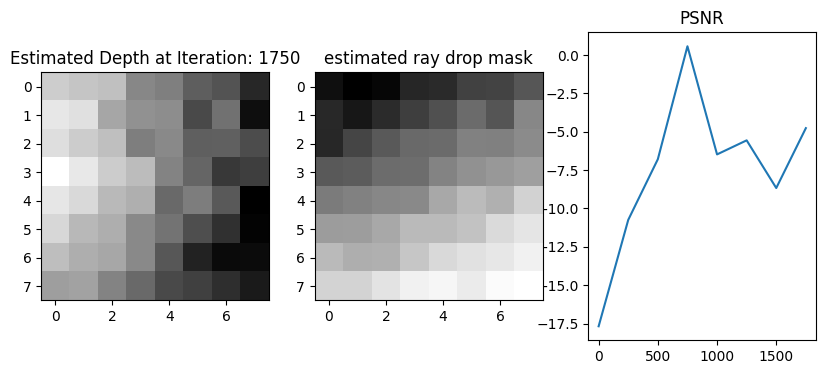

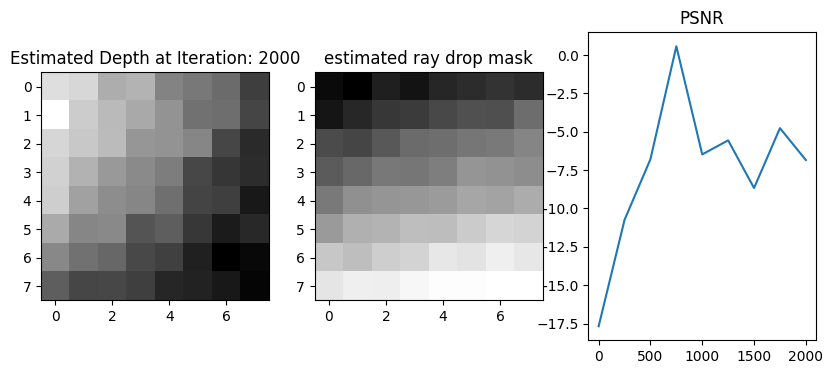

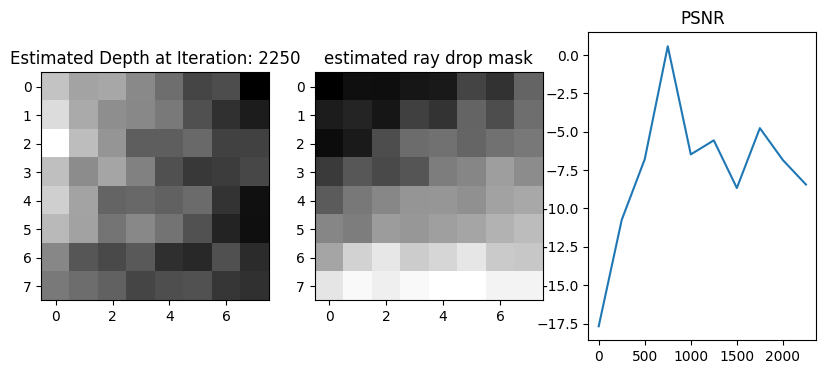

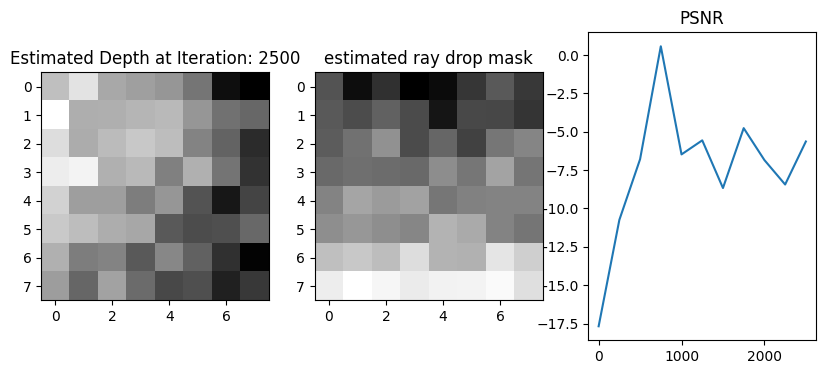

KeyboardInterrupt: 

In [108]:
model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4) #default tiny-NeRF
# optimizer = tf.keras.optimizers.Adam(5e-5)
# optimizer = tf.keras.optimizers.Adam(5e-6)

N_samples = 512 #64 #decrease as needed for VRAM
N_iters = 500_000
psnrs = []
iternums = []
i_plot = 250

phimin = np.deg2rad(-16) 
phimax = np.deg2rad(17.75)
vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)

for i in range(N_iters+1):
    img_i = np.random.randint(images.shape[0])
    target = images[img_i,:,:,:1]
    target_drop_mask = images[img_i,:,:,1:]
    pose = poses[img_i]
    
    #old
#     phimin_patch = vertical_bins[img_i%n_vert_patches] 
#     phimax_patch = vertical_bins[img_i%n_vert_patches + 1]
#     print("image:", img_i, '\n', phimin_patch, phimax_patch)
    #test -- send bins from top to bottom
    phimin_patch = vertical_bins[len(vertical_bins) -1 - (img_i%n_vert_patches+1)] 
    phimax_patch = vertical_bins[len(vertical_bins) -1 - (img_i%n_vert_patches)]
    
    #get ray origins and ray directions
    rays_o, rays_d = get_rays(H, W, pose, phimin_patch, phimax_patch)
    
    with tf.GradientTape() as tape:
        #just calculate loss via comparing depth output vs target (should also be depth!)
        depth, acc, ray_drop = render_rays(model, rays_o, rays_d, near=0., far=2., N_samples=N_samples, rand=True)
        depth = depth[:,:,None]
        ray_drop = ray_drop[:,:,None]
    
        #LiDAR-NeRF LoSS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        ## L_total = L_dist + lam1*L_intensity + lam2*L_raydrop + lam3*L_reg
        
        #Gradient Loss (structural regularization for smooth surfaces)
        thresh = 0.025 #was 0.1 in LiDAR-NeRF
        mask = np.ones(np.shape(target[:,:,0]))
        vertical_grad_target = np.gradient(target[:,:,0])[0] 
        vertical_past_thresh = np.argwhere(tf.abs(vertical_grad_target) > thresh)
        mask[vertical_past_thresh[:,0], vertical_past_thresh[:,1]] = 0
        horizontal_grad_target = np.gradient(target[:,:,0])[1]
        horizontal_past_thresh = np.argwhere(tf.abs(horizontal_grad_target) > thresh)
        mask[horizontal_past_thresh[:,0], horizontal_past_thresh[:,1]] = 0
        vertical_grad_inference = np.gradient(depth[:,:,0])[0]
        horizontal_grad_inference = np.gradient(depth[:,:,0])[1]
        mag_difference = tf.math.sqrt((vertical_grad_target-vertical_grad_inference)**2 + (horizontal_grad_target-horizontal_grad_inference)**2)

        #suppress ray drop areas (for distance and gradient loss)
        L_reg = np.multiply(mag_difference, mask)
        L_reg = L_reg[:,:,None]
        L_reg = tf.reduce_mean(tf.math.multiply(L_reg, target_drop_mask))
        L_reg = tf.cast(L_reg, tf.float32)            
                
        #ray drop loss
        L_raydrop = tf.keras.losses.binary_crossentropy(target_drop_mask, ray_drop)
        L_raydrop = tf.math.reduce_mean(tf.abs(L_raydrop))
    
        #distance loss
        #suppressing ray drop areas
        depth_nondrop = tf.math.multiply(depth, target_drop_mask)
        target_nondrop = tf.math.multiply(target, target_drop_mask)
        L_dist = tf.reduce_mean(tf.abs(depth_nondrop - target_nondrop))
    
        lam1 = 100
        lam2 = 1 #1/(64**2)
        loss = L_dist + lam1*L_reg + lam2*L_raydrop       
#         ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    if i%i_plot==0:
        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, testpose, vertical_bins[-2], vertical_bins[-1]) #constant validation image
#         print(vertical_bins[-2], vertical_bins[-1])
#         sampl = int(np.random.uniform(low=0, high=len(testpose)-1))        
#         rays_o, rays_d = get_rays(H, W, focal, testpose[sampl]) #90/10 split
#         depth, acc = render_rays(model, rays_o, rays_d, near=1., far=64., N_samples=N_samples)
        depth, acc, ray_drop = render_rays(model, rays_o, rays_d, near=0., far=2., N_samples=N_samples)
        depth = depth[:,:,None]
        ray_drop = ray_drop[:,:,None]
#         print(ray_drop)
#         #simple depth only
#         loss = tf.reduce_mean(tf.square(depth[:,:,None] - testimg[:,:,0])) 
#         #ray drop only
#         L_raydrop = tf.keras.losses.binary_crossentropy(testimg[:,:,1], ray_drop)
#         loss = tf.math.reduce_sum(tf.abs(L_raydrop)).numpy()

        #LiDAR-NeRF LoSS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        ## L_total = L_dist + lam1*L_intensity + lam2*L_raydrop + lam3*L_reg
        ##          lam1=1, lam2=1, lam3=100
        ## L_reg --> structural regularization: consider gradient loss only on high-texture areas
        
        target = testimg[:,:,:1]
        target_drop_mask = testimg[:,:,1:]
        
        #Gradient Loss (structural regularization for smooth surfaces)
        thresh = 0.025 #was 0.1 in LiDAR-NeRF
        mask = np.zeros(np.shape(target[:,:,0]))
        vertical_grad_target = np.gradient(target[:,:,0])[0] 
        vertical_past_thresh = np.argwhere(tf.abs(vertical_grad_target) > thresh)
        mask[vertical_past_thresh[:,0], vertical_past_thresh[:,1]] = 1
        horizontal_grad_target = np.gradient(target[:,:,0])[1]
        horizontal_past_thresh = np.argwhere(tf.abs(horizontal_grad_target) > thresh)
        mask[horizontal_past_thresh[:,0], horizontal_past_thresh[:,1]] = 1
        
        vertical_grad_inference = np.gradient(depth[:,:,0])[0]
        horizontal_grad_inference = np.gradient(depth[:,:,0])[1]
        mag_difference = tf.math.sqrt((vertical_grad_target-vertical_grad_inference)**2 + (horizontal_grad_target-horizontal_grad_inference)**2)
        L_reg = tf.reduce_mean(np.multiply(mag_difference, mask))        
        L_reg = tf.cast(L_reg, tf.float32)     
        #suppress ray drop areas
        L_reg = np.multiply(mag_difference, mask)
        L_reg = L_reg[:,:,None]
        L_reg = tf.reduce_mean(tf.multiply(L_reg, target_drop_mask))
        L_reg = tf.cast(L_reg, tf.float32)            
    
        #distance loss
        L_dist = tf.reduce_mean(tf.abs(depth - target))
        
        #ray drop loss
        L_raydrop = tf.keras.losses.binary_crossentropy(target_drop_mask, ray_drop)
        L_raydrop = tf.math.reduce_sum(tf.abs(L_raydrop))
#         print("Ray Drop Loss:", L_raydrop)
        
        lam1 = 100
        lam2 = 1 #1/(64**2)
        loss = L_dist + lam1*L_reg + lam2*L_raydrop       

#         ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)
        psnrs.append(psnr.numpy())
        iternums.append(i)
        p.figure(figsize=(10,4))
        p.subplot(131)
        p.imshow(depth,cmap = "gray")#, norm='log')
        p.title(f'Estimated Depth at Iteration: {i}')
#         p.imshow(testimg[:,:,1],cmap = "gray") #, norm='log')
#         p.title(f'Actual Mask at Iteration: {i}')
        p.subplot(133)
        p.plot(iternums, psnrs)
        p.title('PSNR')
        #look at depth map
        p.subplot(132)
        p.imshow(ray_drop, cmap="gray")#, norm = 'log')
        p.title("estimated ray drop mask")
        p.show()
print('Done')

# Infer point cloud at novel frame

In [109]:
num_view = 64 #128 #number of (rotational?) patches to draw
N_samples = 512 #2048 #64 #does not have to match what was used in training
n_rots = 64 #128 #number of horizontal patches per 2*pi
n_vert_patches = 1 #number of vertical patches between phimin and phimax

H = 64 // n_vert_patches
W = 1024 // n_rots

plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

for j in range(num_view):
# for j in np.linspace(0,7,15):
    #get sensor transformation matrix
    rotm = np.eye(4)

    # account for image crop in rotation -------------------
    #TODO-- will not work if using different focal length for elev/azim
    crop_angle =  -(np.pi/n_rots) + j*(2*np.pi/n_rots) #test
    rotm_crop = R.from_euler('xyz', [0,-crop_angle + np.pi/2,0]).as_matrix()
    rotm[:3,:3] = rotm[:3,:3] @ rotm_crop

    #also need to account for the fact that the LIDAR beam isn't actually centered at horizon
    sensor_elevation_zero_rotm = R.from_euler('xyz', [(phimin+phimax)/2,0,0]).as_matrix()
    rotm[:3,:3] = rotm[:3,:3] @ sensor_elevation_zero_rotm
    # ------------------------------------------------------

    # flip x and z axis
    rotm[0,-1], rotm[2,-1] = rotm[2,-1], rotm[0,-1] 

    rotm[0:3,2] *= -1 # flip sign of y and z axis
    rotm[0:3,1] *= -1
    rotm = rotm[[1,0,2,3],:]
    rotm[2,:] *= -1 # flip whole world upside down
    rotm[2,-1] = 0.55 #x in world frame output
    rotm[0,-1] = -0.0025 #- (i/3) #z in world frame output
    rotm[1,-1] = -.25 #+ (i/6) #y in world frame
    rotm = rotm.astype(np.float32)
    
    phimin = np.deg2rad(-16) 
    phimax = np.deg2rad(17.75)
    vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)
    phimin_patch = vertical_bins[img_i%n_vert_patches] 
    phimax_patch = vertical_bins[img_i%n_vert_patches + 1]
#     print(phimin, phimax)
#     print(phimin_patch, phimax_patch)
#     phimin_patch = phimin #debug
#     phimax_patch = phimax #debug

    #call NeRF using specified novel rotm
    rays_o, rays_d = get_rays(H, W, rotm, phimin_patch, phimax_patch)
    depth, acc, ray_drop = render_rays(model, rays_o, rays_d, near=0., far=2., N_samples=N_samples)
    new_point_cloud_spherical = np.zeros([np.shape(depth)[0]*np.shape(depth)[1],3])
    depth = tf.transpose(depth).numpy() #need this
    depth = np.flip(depth, axis = 0) #needed

    #scale back up to normal size
    depth *= 50 #20
    ray_drop = tf.transpose(ray_drop).numpy() #test
    ray_drop = np.flip(ray_drop, axis = 0) #test
    
    #Ouster OS1-64
    phimin = np.deg2rad(-16) 
    phimax = np.deg2rad(17.75)

    count = 0
    for w in range(W):
        for h in range(H):
#             #draw all points
#             new_point_cloud_spherical[count,0] = depth[w,h] #radius
#             suppress ray dropped points
            if ray_drop[w,h] > 0.95:
                    new_point_cloud_spherical[count,0] = depth[w,h] #radius
            else:
                    new_point_cloud_spherical[count,0] = 0#100
            new_point_cloud_spherical[count,1] = (w-(1024//(2*n_rots)))/(2048//(2*n_rots))*(2*np.pi/n_rots)            
            #was this (for simulated data)
            #TODO: do I need to update this?
            new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/np.shape(depth)[1]) #phi
            count+= 1

    new_point_cloud_spherical[:,1] -= (np.pi/n_rots) - j*(2*np.pi/n_rots) #test

    #if last square patch in sweep, throw away any points that wrap around origin
    if j==11:
        new_point_cloud_spherical= new_point_cloud_spherical[new_point_cloud_spherical[:,1]>=(-2*np.pi + (phimax-phimin))]
    
    new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy()
    new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z 

#     # rainbow by z height
#     zheight = 100*(np.sin(0.25*new_point_cloud_cart[:,2])+1)
#     cname = np.array([1-zheight, zheight, 1.5*zheight]).T.tolist()
#     disp.append(Points(new_point_cloud_cart, c = cname, r = 3, alpha = 0.5))
    disp.append(Points(new_point_cloud_cart, c = 'gray', r = 3, alpha = 0.5))

    
print(testpose)
print("\n", rotm)
    
plt.show(disp, "Newer College NeRF")
ViewInteractiveWidget(plt.window)

[[-0.01987071 -0.99979126  0.00475409 -0.00237682]
 [-0.97870076  0.02042288  0.20427367 -0.272002  ]
 [-0.20432812 -0.00059377 -0.9789023   0.056522  ]
 [ 0.          0.          0.          1.        ]]

 [[ 0.         -0.9998834   0.01527104 -0.0025    ]
 [-0.14673047 -0.01510575 -0.9890612  -0.25      ]
 [ 0.9891765  -0.00224073 -0.14671336  0.55      ]
 [ 0.          0.          0.          1.        ]]


ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [ ]:
#v1-- L_embed = 15 (was 10 before?)
# model.save_weights("models/NCv1.ckpt")
# model.save('models/NCv1.keras')

#v2-- L_embed = 15, trained on 8x8 pixel patches
# model.save_weights("models/NCv2.ckpt")
# model.save('models/NCv2.keras')

# model.load_weights('models/NCv1.ckpt')

# Load and crop depth image data with arbitrary "patch" sizes

In [106]:
from time import sleep
#convert gt from xyzquat to homogenous rotation matrix
n_images = 50 
n_rots = 128 #128    #number of horizontal patches in 360 degrees
n_vert_patches = 8 #8 #number of vertical patcehs between phimin and phimaxs

n_cols_to_skip = n_rots // 8 #remove this much from the beginning and end of each scan
                             #   (do this to remove data with researcher carrying LIDAR)

#Ouster OS1-64
phimin = np.deg2rad(-16) 
phimax = np.deg2rad(17.75)
# phimin = np.deg2rad(-6)    #debug 
# phimax = np.deg2rad(27.75) #debug
vert_fov = np.rad2deg(phimax-phimin)

poses = np.zeros([n_images*n_rots*n_vert_patches,4,4])
images = np.ones([n_images*n_rots*n_vert_patches, 64//n_vert_patches, 1024//n_rots, 2]) #depth image and raydrop

#focal length (in pixels) = Image Size / (2 tan(FOV/2)) #needs to be array!
focal = np.array(np.shape(images)[1]/(2*np.tan((phimax-phimin)/2))) #default image size
H, W = images.shape[1:3]
print(H, W)

for i in range(n_images):
    #load point cloud
    idx = i*10 + 600 #1450 #700    
    fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
    pc1 = np.load(fn1)
    pc1 = np.flip(pc1, axis = 0)# uncomment to flip and maintain CCW convention used in VICET

    #convert to depth image
    pc1_spherical = LC.c2s(LC,pc1).numpy() #[r, theta, phi]
    pcs = np.reshape(pc1_spherical, [-1,64,3])
    pcs = np.flip(pcs, axis = 1)
    raw_data = pcs[:,:,:]
    raw_data = np.transpose(pcs, [1,0,2])

    #destagger depth images (OS1 unit has delay in sensor return bus)
    data = np.zeros([64, 1024])
    for k in range(np.shape(data)[0]//4):
        data[4*k,1:-8] = raw_data[4*k,9:,0]
        data[4*k+1,1:-2] = raw_data[4*k+1,3:,0]
        data[4*k+2,4:] = raw_data[4*k+2,:-4,0]
        data[4*k+3,10:] = raw_data[4*k+3,:-10,0]
    data = np.flip(data, axis =1)

    for j in range(n_rots):
        for k in range(n_vert_patches):
            #get cropped depth image ~~~~~~~~~~~~~~~~~~~~    
            image_width = 1024//n_rots
            image_height = 64//n_vert_patches
#             pcs = data[:,j*image_width:(j+1)*image_width] #full vertical, only partial horizontal
            pcs = data[k*image_height:(k+1)*image_height,j*image_width:(j+1)*image_width] #crop vertically and horizontally
    
            #save depth information to first channel
#             images[j+(i*n_rots),:,:,0] = pcs #for full vertical
            images[k+(j+(i*n_rots))*n_vert_patches,:,:,0] = pcs #TODO-- fix this?
#             print(k+(j+(i*n_rots))*n_vert_patches)

            #save raydrop mask to 2nd channel
            a = np.argwhere(pcs == 0)
            #TODO: why do some distant windows register as being close (but not non-returns)??
            images[k+(j+(i*n_rots))*n_vert_patches, a[:,0],a[:,1],1] = 0 

            #get transformation matrix ~~~~~~~~~~~~~~~~~~
            rotm = np.eye(4)
            rotm[1,3] = -gt[idx,2] #x
            rotm[2,3] = gt[idx,3] #y
            rotm[0,3] = -gt[idx,4] #z
            rotm[:3,:3] = R.from_quat(gt[idx,5:]).as_matrix() 

            #orient yellow (-z) pointing forward
            fix1 = R.from_euler('xyz', [0,-np.pi/2,0]).as_matrix()
            fix2 = R.from_euler('xyz', [np.pi/2,0,0]).as_matrix()
            rotm[:3,:3] = rotm[:3,:3] @ fix1 @ fix2
            temp = R.from_matrix(rotm[:3,:3]).as_euler('zxy')
            rotm[:3,:3] = R.from_euler('xyz', [temp[0], temp[1], -temp[2]]).as_matrix()

            #account for image crop in rotation using non-symmetric FOV
            crop_angle = j*(2*np.pi/n_rots)

            #account for the fact that sensor points back and to the left
#             crop_angle -= np.pi/4  #was this
            #used this rotation value on the VICET paper-- (I don't think their setup was a perfect 45deg)
            crop_angle -= np.deg2rad(44.97)
            rotm_crop = R.from_euler('xyz', [0,-crop_angle + np.pi/2,0]).as_matrix()
            
            rotm[:3,:3] = rotm[:3,:3] @ rotm_crop

            #also need to account for the fact that the LIDAR beam isn't actually centered at horizon
            #works for single vertical patch
            sensor_elevation_zero_rotm = R.from_euler('xyz', [(phimin+phimax)/2,0,0]).as_matrix() 
    
            #test--- set rotation angle for vertical patches when setting up poses so we won't have to calculate it later 
#             sensor_elevation_zero_rotm = R.from_euler('xyz', [(phimin+phimax)/2 + ((n_vert_patches-1)/2 - k)*((phimax-phimin)/n_vert_patches),0,0]).as_matrix()
    
            rotm[:3,:3] = rotm[:3,:3] @ sensor_elevation_zero_rotm
            #translate all frames above xy plane
            rotm[2,-1] += 45 

            #Linearly scale down translations and ranges ~~~~~~~~~~~~~~~~~~~
            rotm[:3,-1] *= 0.02 #0.05
            images[k+(j+(i*n_rots))*n_vert_patches,:,:,0] *= 0.02 #0.05
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#             poses[j+(i*n_rots)] = rotm
            poses[k+(j+(i*n_rots))*n_vert_patches] = rotm

images = images.astype(np.float32)
poses = poses.astype(np.float32)

print("num poses:", len(poses))

# # Remove patches where sensor is occluded by person holding lidar ~~~~~~~~~~
# ## TODO-- make this adaptable to different patch resolutions

#calculte how many columns of patches we need to skip at the beginning and end of each scan to avoid
print("n_rots:", n_rots)
# n_cols_to_skip = 0 #debug
print("n_cols_to_skip:", n_cols_to_skip)

bad_idx = np.zeros([0,n_rots - 2*n_cols_to_skip])
a = np.linspace(0,n_rots*n_images*n_vert_patches-1,n_rots*n_images*n_vert_patches)
print(np.shape(a))
for i in range(n_vert_patches*n_cols_to_skip):
    bad_i_left = a[i::n_rots*n_vert_patches]
    bad_idx = np.append(bad_idx, bad_i_left)
#     print("\n bad_idx_left:", bad_i_left)

    bad_i_right = a[(i+n_vert_patches*(n_rots-n_cols_to_skip))::n_rots*n_vert_patches]
    bad_idx = np.append(bad_idx, bad_i_right)
#     print("\n bad_idx_right:", bad_i_right)
    
bad_idx = np.sort(bad_idx)
all_idx = np.linspace(0,n_rots*n_images*n_vert_patches-1,n_rots*n_images*n_vert_patches)
good_idx = np.setdiff1d(all_idx, bad_idx).astype(int)

# print(good_idx)

images = images[good_idx,:,:,:]
poses = poses[good_idx,:,:]
# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# test on one only
testimg, testpose = images[-1], poses[-1]
images = images[:-1,...,:3]
poses = poses[:-1]

# #90/10 split
# cutoff = (n_images*9)//10
# print(cutoff)
# testimg, testpose = images[cutoff:], poses[cutoff:]
# images = images[:cutoff,...,:3]
# poses = poses[:cutoff]

8 8
num poses: 51200
n_rots: 128
n_cols_to_skip: 16
(51200,)


In [107]:
num_draw = 48 #128 #48 #number of patches to draw
N_samples = 64 #only when visualizing all test points

#Ouster OS1-64
phimin = np.deg2rad(-16) 
phimax = np.deg2rad(17.75)
# phimin = np.deg2rad(-6) 
# phimax = np.deg2rad(27.75)

#test
vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)

plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True, sharecam = False) #axes = 4 (simple), 1(scale)
disp=[]

for count in range(num_draw):
    
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    look_at_pose = count
    c2w = poses[look_at_pose]
    c2w = tf.cast(c2w, tf.float32)
    near = 0.
    far = 64.
    
    #NOTE: not possible to infer phimin_temp/ phimax_temp from c2w matrix!
    
    #was this
#     phimin_temp = vertical_bins[count%n_vert_patches] 
#     phimax_temp = vertical_bins[count%n_vert_patches + 1]
    #test -- send bins from top to bottom
    phimin_temp = vertical_bins[len(vertical_bins) -1 - (count%n_vert_patches+1)] 
    phimax_temp = vertical_bins[len(vertical_bins) -1 - (count%n_vert_patches)]

    #reformat for LiDAR depth measurements ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    vert_fov = np.rad2deg(phimax-phimin)
    #[r, theta, phi]
    dirs_test = tf.stack([-tf.ones_like(i), #r
                          #theta
                          (i - (1024//(2*n_rots)))  /(2048//(2*n_rots)) * (2*np.pi/n_rots), #for uninterpolated images
                          #phi
#                           (phimax + phimin)/2 + ((-j+31.5)/63)*(phimax-phimin) -np.pi/2 #single elevation patch
                        (phimax_temp + phimin_temp)/2 + ((-j+(32//n_vert_patches))/(64//n_vert_patches))*(phimax_temp-phimin_temp) -np.pi/2 #looks good but requries manually setting elevation angle
#                           (phimax + phimin)/2 + ((-j+(32//n_vert_patches))/(64//n_vert_patches))*((phimax - phimin)/n_vert_patches) - np.pi/2 #YES
                         ], -1)
    dirs_test = tf.reshape(dirs_test,[-1,3])
    dirs_test = LC.s2c(LC, dirs_test)    
    
    #need to rotate red points into same frame as blue points 
    rotm = R.from_euler('xyz', [0,-np.pi/2 + (phimax + phimin)/2,0]).as_matrix()
    # Move rotm with crops rather than having to re-create crop process at render time? -- nope (spacing at tops and bottoms gets messed up)
#     rotm = R.from_euler('xyz', [0,-np.pi/2 + (phimax_temp + phimin_temp)/2,0]).as_matrix() 
    dirs_test = dirs_test @ rotm
    dirs_test = dirs_test @ tf.transpose(c2w[:3,:3])
    # aligns dirs, doesn't get pts_flat to work yet
    dirs_test = dirs_test @ (c2w[:3,:3] 
                          @ R.from_euler('xyz', [0,0,np.pi/2]).as_matrix() #looked good but converged slightly off
                          @ np.linalg.pinv(c2w[:3,:3]) )

    rotm_fix = (c2w[:3,:3] 
                @ np.linalg.pinv(c2w[:3,:3]))
    rays_d_test = tf.reduce_sum(dirs_test[..., np.newaxis, :] * rotm_fix, -1) #looks like I need to do this instead
    rays_o_test = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d_test))
    z_vals_test = tf.linspace(near, far, N_samples) 
    z_vals_test += tf.random.uniform(list(rays_o_test.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    #[image_height, image_width, batch_size, 3]
    pts_test = rays_o_test[...,None,:] + rays_d_test[...,None,:] * z_vals_test[...,:,None]
    pts_flat_test = tf.reshape(pts_test, [-1,3])

    #random color
    cname = np.array([255*(np.random.rand()), 255*(np.random.rand()), 255*(np.random.rand())]).T.tolist()
    #use depth as color
# #     d = images[count,:,:,0].flatten()
#     d = images[30*num_draw + count,:,:,0].flatten()
#     cname = np.array([d/1.5, d/1.5, d/1.5]).T.tolist()
       
    disp.append(Points(dirs_test, c = cname, r = 3, alpha = 0.5))
#     disp.append(Points(dirs_test, c = 'pink', r = 3, alpha = 0.8))
#     disp.append(Points(dirs_test[:100], c = 'red', r = 5, alpha = 0.8))
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    #draw frames first pose
    #forward view direction (-z in NeRF c2w convention) 
    headings = poses[look_at_pose,:3,:3] @ np.array([0,0,-0.3])
    disp.append(Arrows(np.zeros([3,1]), (np.zeros([3,1]) + headings), c = "yellow"))
    # x
    headings = poses[look_at_pose,:3,:3] @ np.array([0.3,0,0])
    disp.append(Arrows(np.zeros([3,1]), (np.zeros([3,1]) + headings), c = "red"))
    #y
    headings = poses[look_at_pose,:3,:3] @ np.array([0,0.3,0])
    disp.append(Arrows(np.zeros([3,1]), (np.zeros([3,1]) + headings), c = "green"))
    #z
    headings = poses[look_at_pose,:3,:3] @ np.array([0,0,0.3])
    disp.append(Arrows(np.zeros([3,1]), (np.zeros([3,1]) + headings), c = "blue"))

plt.show(disp, "dirs", at = 0)
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

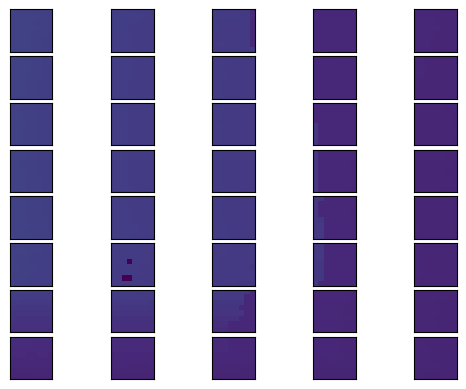

In [81]:
#debug: view grid of patches
view_scan_num = 0 #which scan to look at
num_view_rots = 5

fig, ax = p.subplots(n_vert_patches, num_view_rots)

for i in range(num_view_rots):
    for j in range(n_vert_patches):
        ax[j,i].imshow(images[num_draw*view_scan_num + j + i*n_vert_patches,:,:,0], vmin = 0, vmax = 1)
#         ax[j,i].imshow(np.flip(images[-(j + i*n_vert_patches),:,:,0], axis = 0), vmin = 0, vmax = 4)
        ax[j,i].get_xaxis().set_visible(False)
        ax[j,i].get_yaxis().set_visible(False)
        ax[j,i].set_aspect(W/H)
p.subplots_adjust(wspace=0.1, hspace=0.1)

In [ ]:
## view patches (assumes sigle n_vert_patches == 1)
# %matplotlib notebook
fig, ax = p.subplots(2,5)
ax[0,0].set_title("depth image patches for training")

# ax[0,0].imshow(images[0,:,:,0])#, vmin=0, vmax=64)
# ax[0,1].imshow(images[1,:,:,0])#, vmin=0, vmax=64)
# ax[0,2].imshow(images[2,:,:,0])#, vmin=0, vmax=64)
# ax[0,3].imshow(images[3,:,:,0])#, vmin=0, vmax=64)
# ax[0,4].imshow(images[4,:,:,0])#, vmin=0, vmax=64)

# ax[0,0].imshow(images[-20,:,:,0])#, vmin=0, vmax=64)
# ax[0,1].imshow(images[-19,:,:,0])#, vmin=0, vmax=64)
# ax[0,2].imshow(images[-18,:,:,0])#, vmin=0, vmax=64)
# ax[0,3].imshow(images[-17,:,:,0])#, vmin=0, vmax=64)
# ax[0,4].imshow(images[-16,:,:,0])#, vmin=0, vmax=64)

ax[0,0].imshow(images[-4,:,:,0])#, vmin=0, vmax=64)
ax[0,1].imshow(images[-3,:,:,0])#, vmin=0, vmax=64)
ax[0,2].imshow(images[-2,:,:,0])#, vmin=0, vmax=64)
ax[0,3].imshow(images[-1,:,:,0])#, vmin=0, vmax=64)
ax[0,4].imshow(testimg[:,:,0])#, vmin=0, vmax=64)

ax[1,0].set_title("ray drop masks")
ax[1,0].imshow(images[-4,:,:,1],cmap="gray", vmin=0,vmax=1)
ax[1,1].imshow(images[-3,:,:,1],cmap="gray", vmin=0,vmax=1)
ax[1,2].imshow(images[-2,:,:,1],cmap="gray", vmin=0,vmax=1)
ax[1,3].imshow(images[-1,:,:,1],cmap="gray", vmin=0,vmax=1)
ax[1,4].imshow(testimg[:,:,1],cmap="gray", vmin=0,vmax=1)

In [ ]:
phimin = np.deg2rad(-16) 
phimax = np.deg2rad(17.75)
print(phimin, phimax)

vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)
print(vertical_bins, "\n")

for count in range(10):
    phimin_temp = vertical_bins[count%n_vert_patches] 
    phimax_temp = vertical_bins[(count)%n_vert_patches + 1]
    print(phimin_temp, phimax_temp)


# Animate GIF

In [ ]:
num_frames = 50
num_view = 64 #128 #number of (rotational?) patches to draw
n_rots = 64 #128 #number of horizontal patches per 2*pi
n_vert_patches = 1 #number of vertical patches between phimin and phimax
N_samples = 2048 #64 #does not have to match what was used in training?? 

H = 64
W = 1024 // n_rots

for i in range(num_frames):
    print(i)
    plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), offscreen=True)
    disp=[] 
    
    for j in range(num_view):
    # for j in np.linspace(0,7,15):
        #get sensor transformation matrix
        rotm = np.eye(4)

        # account for image crop in rotation -------------------
        #TODO-- will not work if using different focal length for elev/azim
        crop_angle =  -(np.pi/n_rots) + j*(2*np.pi/n_rots) #test
        rotm_crop = R.from_euler('xyz', [0,-crop_angle + np.pi/2,0]).as_matrix()
        rotm[:3,:3] = rotm[:3,:3] @ rotm_crop

        #also need to account for the fact that the LIDAR beam isn't actually centered at horizon
        sensor_elevation_zero_rotm = R.from_euler('xyz', [(phimin+phimax)/2,0,0]).as_matrix()
        rotm[:3,:3] = rotm[:3,:3] @ sensor_elevation_zero_rotm
        # ------------------------------------------------------

        # flip x and z axis
        rotm[0,-1], rotm[2,-1] = rotm[2,-1], rotm[0,-1] 

        rotm[0:3,2] *= -1 # flip sign of y and z axis
        rotm[0:3,1] *= -1
        rotm = rotm[[1,0,2,3],:]
        rotm[2,:] *= -1 # flip whole world upside down
        rotm[2,-1] = 1. #4 #x in world frame output
        rotm[0,-1] = -0.005 #- (i/3) #z in world frame output
        rotm[1,-1] = -.9 + (i/100) #y in world frame
        rotm = rotm.astype(np.float32)

        phimin = np.deg2rad(-16) 
        phimax = np.deg2rad(17.75)
        vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)
        phimin_patch = vertical_bins[img_i%n_vert_patches] 
        phimax_patch = vertical_bins[img_i%n_vert_patches + 1]
    #     print(phimin, phimax)
    #     print(phimin_patch, phimax_patch)
    #     phimin_patch = phimin #debug
    #     phimax_patch = phimax #debug

        #call NeRF using specified novel rotm
        rays_o, rays_d = get_rays(H, W, rotm, phimin_patch, phimax_patch)
        depth, acc, ray_drop = render_rays(model, rays_o, rays_d, near=0., far=4., N_samples=N_samples)
        new_point_cloud_spherical = np.zeros([np.shape(depth)[0]*np.shape(depth)[1],3])
        depth = tf.transpose(depth).numpy() #need this
        depth = np.flip(depth, axis = 0) #needed

        #scale back up to normal size
        depth *= 20
        ray_drop = tf.transpose(ray_drop).numpy() #test
        ray_drop = np.flip(ray_drop, axis = 0) #test

        #Ouster OS1-64
        phimin = np.deg2rad(-16) 
        phimax = np.deg2rad(17.75)

        count = 0
        for w in range(W):
            for h in range(H):
    #             #draw all points
    #             new_point_cloud_spherical[count,0] = depth[w,h] #radius
    #             suppress ray dropped points
                if ray_drop[w,h] > 0.95:
                        new_point_cloud_spherical[count,0] = depth[w,h] #radius
                else:
                        new_point_cloud_spherical[count,0] = 0#100
                new_point_cloud_spherical[count,1] = (w-(1024//(2*n_rots)))/(2048//(2*n_rots))*(2*np.pi/n_rots)            
                #was this (for simulated data)
                #TODO: do I need to update this?
                new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/np.shape(depth)[1]) #phi
                count+= 1

        new_point_cloud_spherical[:,1] -= (np.pi/n_rots) - j*(2*np.pi/n_rots) #test

        #if last square patch in sweep, throw away any points that wrap around origin
        if j==11:
            new_point_cloud_spherical= new_point_cloud_spherical[new_point_cloud_spherical[:,1]>=(-2*np.pi + (phimax-phimin))]

        new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy()
        new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z 

        #translate to keep camera fixed in place
        new_point_cloud_cart[:,0] += -5 + 3*i/15
    
        # rainbow by z height
        zheight = 65*(np.sin(0.25*new_point_cloud_cart[:,2])+1)
        cname = np.array([1-zheight, zheight, 1.5*zheight]).T.tolist()
        disp.append(Points(new_point_cloud_cart, c = cname, r = 2., alpha = 0.5))
        
        
    cam = dict(
        pos=(37.30093, 95.07558, 94.30112),
        focalPoint=(8.715815, 0.7997105, -0.04585656),
        viewup=(-0.2068594, -0.6600254, 0.7222019),
        distance=136.4053,
        clippingRange=(53.80149, 240.4701),
    )

    plt.show(disp, "Novel Point Cloud From NeRF at [" 
             + str(np.round(-rotm[2,-1]*20, decimals=2)) + ", " + str(np.round(-rotm[1,-1]*20, decimals=2)) + ", " + str(np.round(-rotm[0,-1]*20, decimals=2)) + "]",
             camera= cam).screenshot("lidar_nerf_demo/Newer_College_V2_" + str(i) + ".png")
    plt.clear()
    plt.close()
# ViewInteractiveWidget(plt.window)

# Remove motion distortion from raw point cloud data used to train NeRF

I believe directly training on motion-distorted raw point clouds is responsible for the "wiggly" motion of some walls observed in the rendered GIFs 

In [66]:
#load HD Map
pl = '/media/derm/06EF-127D4/Newer College Dataset/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply'
HD_map = trimesh.load(pl).vertices
show_nth = 5 #10
submap = HD_map[::show_nth]
plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp=[]
disp.append(Points(submap, c = "gray", r = 2, alpha = 0.1)) 
plt.show(disp, "HD Map")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [356]:
dir_name = "/media/derm/06EF-127D4/Newer College Dataset/"
experiment_name = "01_short_experiment-20230331T172433Z-009/01_short_experiment/"
fn_gt = dir_name + experiment_name + "ground_truth/registered_poses.csv"
# print(fn_gt)

#sec,nsec,x,y,z,qx,qy,qz,qw
gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)

seconds = gt[:, 0]
nano_seconds = gt[:, 1]
xyz = gt[:, 2:5]
qxyzw = gt[:, 5:]
num_poses = qxyzw.shape[0]
poses = np.eye(4, dtype=np.float64).reshape(1, 4, 4).repeat(num_poses, axis=0)
poses[:, :3, :3] = R.from_quat(qxyzw).as_matrix()
poses[:, :3, 3] = xyz
T_CL = np.eye(4, dtype=np.float32)
T_CL[:3, :3] = R.from_quat([0.0, 0.0, 0.924, 0.383]).as_matrix() #was this --1134.97 deg
T_CL[:3, 3] = np.array([-0.084, -0.025, 0.050], dtype=np.float32) #was this
poses = np.einsum("nij,jk->nik", poses, T_CL)
initial_pose = np.linalg.inv(poses[0]) 
poses_timestamps = seconds * 10e9 + nano_seconds
poses = np.einsum("ij,njk->nik", np.linalg.inv(poses[0]), poses)

# print(poses)

In [372]:
idx = 900 #1450 #700    
fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
fn2 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx +1) + ".npy"
pc1 = np.load(fn1)
pc2 = np.load(fn2)
# pc1 = np.flip(pc1, axis = 0)# uncomment to flip and maintain CCW convention used in VICET
# pc2 = np.flip(pc2, axis = 0)# uncomment to flip and maintain CCW convention used in VICET

<IPython.core.display.Javascript object>


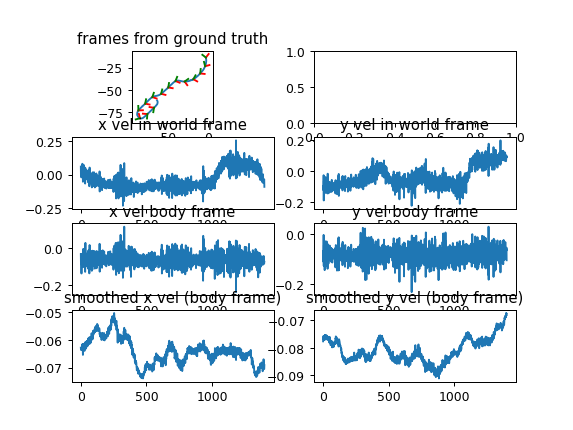

In [373]:
# %matplotlib notebook

#TODO: get body-frame euler angles from ground truth
fig, ax = p.subplots(4,2)
start_idx = 600
end_idx = 2000

ax[0,0].set_title("frames from ground truth")
ax[0,0].plot(poses[start_idx:end_idx,0,-1], poses[start_idx:end_idx,1,-1])
ax[0,0].set_aspect(1)

#plot velocity in world frame
vel_world_frame = np.diff(poses[:,:3,-1], axis = 0)
ax[1,0].set_title("x vel in world frame")
ax[1,0].plot(vel_world_frame[start_idx:end_idx,0])
ax[1,1].set_title("y vel in world frame")
ax[1,1].plot(vel_world_frame[start_idx:end_idx,1])

#get velocity in body frame
# rotm = R.from_euler('xyz',[0,0,3*np.pi/4]).as_matrix()
rotm = R.from_euler('xyz',[0,0,0]).as_matrix()
# vel_body_frame = poses[1:,:3,:3] @ rotm @ vel_world_frame[:,:,None]
vel_body_frame = np.linalg.pinv(poses[1:,:3,:3]) @ rotm @ vel_world_frame[:,:,None]

vel_body_frame = vel_body_frame[:,:,0]
ax[2,0].set_title("x vel body frame")
ax[2,0].plot(vel_body_frame[start_idx:end_idx,0])
ax[2,1].set_title("y vel body frame")
ax[2,1].plot(vel_body_frame[start_idx:end_idx,1])

#smooth out velocity estimates
def moving_average(a, n=10):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

window=50
MAx = moving_average(vel_body_frame[start_idx:end_idx+window-1,0], n = window)
ax[3,0].plot(MAx)
ax[3,0].set_title("smoothed x vel (body frame)")
MAy = moving_average(vel_body_frame[start_idx:end_idx+window-1,1], n = window)
ax[3,1].plot(MAy)
ax[3,1].set_title("smoothed y vel (body frame)")
MAz = moving_average(vel_body_frame[start_idx:end_idx+window-1,2], n = window)

vel_body_frame = np.array([MAx, MAy, MAz]).T

#plot heading on map
for i in range(start_idx,end_idx,100):
    heading = np.array([5,0,0]) @ np.linalg.pinv(poses[i, :3, :3]) @ rotm
    end = poses[i, :3, -1] + heading
    ax[0,0].plot([poses[i,0,-1], end[0]], [poses[i,1,-1], end[1]], color='red' )

    heading = np.array([0,5,0]) @ np.linalg.pinv(poses[i, :3, :3]) @ rotm
    end = poses[i, :3, -1] + heading
    ax[0,0].plot([poses[i,0,-1], end[0]], [poses[i,1,-1], end[1]], color='green' )

<IPython.core.display.Javascript object>


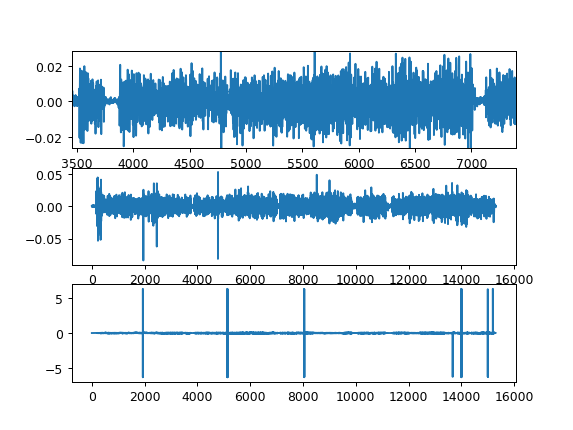

In [374]:
#get rotational velocity
#get straight diff (was this)-- not going to work?
rot_vel_euls = np.diff(R.from_matrix(poses[:,:3,:3]).as_euler('xyz'), axis = 0)

# rot_vel_euls = np.zeros([len(poses)-1,3])
# for i in range(1,len(poses)):
#     pose_i_in_last_frame = np.linalg.pinv(poses[i-1,:3,:3]) @ poses[i,:3,:3]
#     end = R.from_matrix(pose_i_in_last_frame).as_euler('xyz')
#     rot_vel_euls[i-1] = end - R.from_matrix(poses[i-1,:3,:3]).as_euler('xyz')
# rot_vel_euls = np.diff(rot_vel_euls, axis = 0)

fig, ax = p.subplots(3)
ax[0].plot(rot_vel_euls[:,0])
ax[0].set_label("roll")
ax[1].plot(rot_vel_euls[:,1])
ax[1].set_label("pitch")
ax[2].plot(rot_vel_euls[:,2])
ax[2].set_label("yaw")

In [375]:
from remove_motion_basic import linear_correction_old as lc
m_hat = np.array([vel_body_frame[idx,0],
                  vel_body_frame[idx,1],
                  vel_body_frame[idx,2],
                  -rot_vel_euls[idx-1,0],
                  -rot_vel_euls[idx-1,1],
                  -rot_vel_euls[idx-1,2]
#                   0,0,0
                 ])
rectified_pc1 = lc(pc1, m_hat, period_lidar=1.)

pc1 = np.flip(pc1, axis = 0)# uncomment at the end to get image projection to work
rectified_pc1 = np.flip(rectified_pc1, axis = 0)# uncomment at the end to get image projection to work

In [376]:
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

#transform map to pc1 frame (for debug)
submap_in_pc1_frame = (np.linalg.pinv(poses[idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
submap_in_pc1_frame = submap_in_pc1_frame[:,:3]

disp.append(Points(submap_in_pc1_frame, c = "black", r = 3, alpha = 0.1)) ##CB2314


# DRAW SCANS 1, 2
disp.append(Points(pc1, c = '#a65852', r = 3)) #red
# disp.append(Points(rectified_pc1, c = '#2c7c94', r = 3)) #blue
## purple -> green
color = 255*np.linspace(0,1,len(rectified_pc1)) 
cname = np.array([255-color, color, 255-color]).T.tolist()
disp.append(Points(rectified_pc1, c=cname,  r = 3.5, alpha =0.5))


plt.show(disp, "01 Short Experiment Frame #" + str(idx))
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1920)

In [100]:
print(np.rad2deg(R.from_quat([0.0, 0.0, 0.924, 0.383]).as_euler('xyz')))
print(np.rad2deg(-np.pi/4 + np.pi/2))

[  0.          0.        134.9717747]
45.0
